<a href="https://colab.research.google.com/github/ashish1610dhiman/pinn_option_pricing/blob/main/european_call_pricing_0_ad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
from io import IncrementalNewlineDecoder
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
%matplotlib inline

### Analytical solution

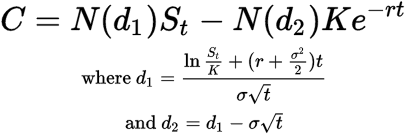

In [ ]:
S = torch.Tensor([80]).requires_grad_()
t = torch.Tensor([0]).requires_grad_()
sigma = torch.Tensor([0.3]).requires_grad_()
r = torch.Tensor([0.05]).requires_grad_()
K = torch.Tensor([70])
T = torch.Tensor([1])
t2m = T-t

d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m)/(sigma * torch.sqrt(t2m))
d2 = d1 - sigma * torch.sqrt(t2m)

In [ ]:
N0 = lambda value: 0.5 * (1 + torch.erf((value/2**0.5))) #normal cdf
Nd1 = N0(d1)
Nd2 = N0(d2)
C = S* Nd1 - K* Nd2 *torch.exp(-r*t2m)
print("Option Price:", C.item())

Option Price: 17.01496124267578


### Differential eqn

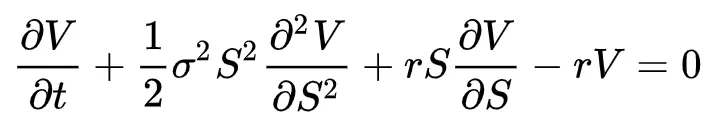

In [ ]:
dCdt = tgrad.grad(C, t, create_graph=True, only_inputs=True)[0]
dCdt

tensor([-5.8385], grad_fn=<NegBackward0>)

In [27]:
dCdS = tgrad.grad(C, S, create_graph=True, only_inputs=True)[0]
d2CdS2 = tgrad.grad(dCdS, S, create_graph=True, only_inputs=True)[0]
dCdvol = tgrad.grad(C, sigma, create_graph=True, only_inputs=True)[0]
dCdS,d2CdS2,dCdvol

(tensor([0.7769], grad_fn=<AddBackward0>),
 tensor([0.0124], grad_fn=<AddBackward0>),
 tensor([23.8776], grad_fn=<AddBackward0>))

In [28]:
dCdt.item() + ((0.5*sigma**2) * (S**2)*d2CdS2.item() )+ r*S*dCdS.item() - r*C

tensor([0.], grad_fn=<SubBackward0>)

### PDE Modelling for European option

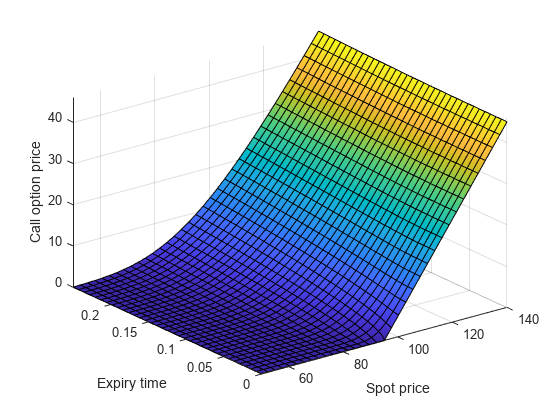

In [130]:
K = 40
r = 0.05
sigma = 0.25
T = 1
S_range = [0, 130]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)

In [131]:
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1)) #price
    return X, y

get_diff_data(10)

(array([[5.52976105e-01, 2.93999812e+01],
        [6.85552992e-02, 3.42295773e+01],
        [7.64141287e-01, 1.11870101e+02],
        [9.84267225e-01, 1.19494359e+01],
        [1.38604167e-01, 1.31262981e+01],
        [6.92498229e-01, 6.38601285e+01],
        [3.81241904e-01, 9.30711411e+01],
        [5.91884514e-01, 1.01505112e+02],
        [4.10112725e-01, 2.43050737e+01],
        [3.34133565e-01, 3.84630240e+01]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [132]:
def get_ivp_data(n):
    X = np.concatenate([np.ones((n, 1)), #all at expiry time
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)

    return X, y

get_ivp_data(10)

(array([[  1.        ,  31.89673087],
        [  1.        ,  32.70070949],
        [  1.        ,  75.71603284],
        [  1.        ,  60.42305789],
        [  1.        ,  55.41777424],
        [  1.        , 107.28225174],
        [  1.        ,  82.2336849 ],
        [  1.        ,  53.95543021],
        [  1.        , 121.04969759],
        [  1.        ,  11.92252821]]),
 array([[ 0.        ],
        [ 0.        ],
        [35.71603284],
        [20.42305789],
        [15.41777424],
        [67.28225174],
        [42.2336849 ],
        [13.95543021],
        [81.04969759],
        [ 0.        ]]))

In [133]:
def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))

    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)

    return X1, y1, X2, y2



* BVP 1 $S = S_{min}$: 0

* BVP2 ($S = S_{max}$): $S_{max} - K \cdot e^{-rt}$

* IVP (t=T): $max(S-K,0)$ *call this initial but corresponds to expiry*

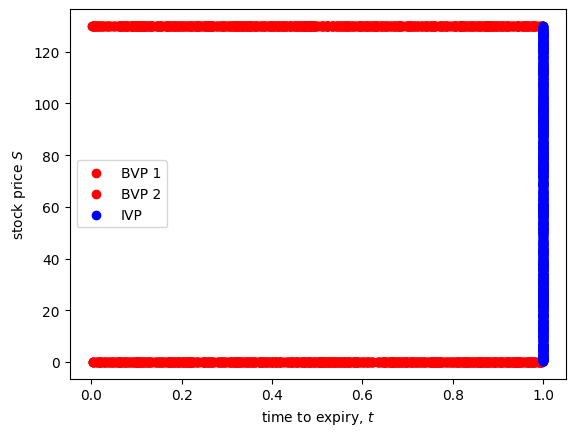

In [134]:
bvp_x1,bvp_y1,bvp_x2,bvp_y2 = get_bvp_data(1000)
ivp_x1,ivp_y1 = get_ivp_data(1000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "red")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.xlabel("time to expiry, $t$")
plt.ylabel("stock price $S$")
plt.legend()

### Simulation with PINN

In [135]:
class european_call(nn.Module):
    "Defines a Phsyics informed network"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.LeakyReLU(negative_slope=0.07)
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation,\
                            nn.Dropout(p=0.3)]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [136]:
model = european_call(2,1,64,8)
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)

In [137]:
N_sample = 500
physics_lr = 5e-1

loss_history=[]

for i in range(20000):
    optimizer.zero_grad()

    # Get IVP data
    ivp_x, ivp_y = get_ivp_data(N_sample)
    ivp_x_tensor = torch.from_numpy(ivp_x).float()
    ivp_y_tensor = torch.from_numpy(ivp_y).float()
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1, bvp_y1, bvp_x2, bvp_y2 = get_bvp_data(N_sample)
    bvp_x1_tensor = torch.from_numpy(bvp_x1).float()
    bvp_y1_tensor = torch.from_numpy(bvp_y1).float()
    bvp_x2_tensor = torch.from_numpy(bvp_x2).float()
    bvp_y2_tensor = torch.from_numpy(bvp_y2).float()
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y1_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1, y1 = get_diff_data(N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_()
    y1 = torch.from_numpy(y1).float()
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + 0.5 * ((sigma * S1) ** 2) * d2VdS2 + r * S1 * dVdS - r * y1_hat
    loss2 = physics_lr * torch.mean(bs_pde ** 2)

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()


    # Plot the result as training progresses
    if (i + 1) % 200 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.6f}")


Epoch 200, Loss: 4338.735352
Epoch 400, Loss: 4187.789551
Epoch 600, Loss: 4151.227051
Epoch 800, Loss: 4150.271484
Epoch 1000, Loss: 4146.823242
Epoch 1200, Loss: 4144.262695
Epoch 1400, Loss: 4141.638184
Epoch 1600, Loss: 4141.936035
Epoch 1800, Loss: 4146.155273
Epoch 2000, Loss: 4141.155762
Epoch 2200, Loss: 4144.672852
Epoch 2400, Loss: 4141.062988
Epoch 2600, Loss: 4138.125977
Epoch 2800, Loss: 4138.738281
Epoch 3000, Loss: 4138.519531
Epoch 3200, Loss: 4141.119141
Epoch 3400, Loss: 4135.357910
Epoch 3600, Loss: 4135.113770
Epoch 3800, Loss: 4145.651855
Epoch 4000, Loss: 4140.051758
Epoch 4200, Loss: 4145.935059
Epoch 4400, Loss: 4139.860840
Epoch 4600, Loss: 4142.684082
Epoch 4800, Loss: 4143.577148
Epoch 5000, Loss: 4143.665039
Epoch 5200, Loss: 4138.397949
Epoch 5400, Loss: 4138.320312
Epoch 5600, Loss: 4140.677734
Epoch 5800, Loss: 4141.418945
Epoch 6000, Loss: 4139.811035
Epoch 6200, Loss: 4137.329102
Epoch 6400, Loss: 4142.593750
Epoch 6600, Loss: 4142.543457
Epoch 6800, Lo

Text(0, 0.5, 'Log loss')

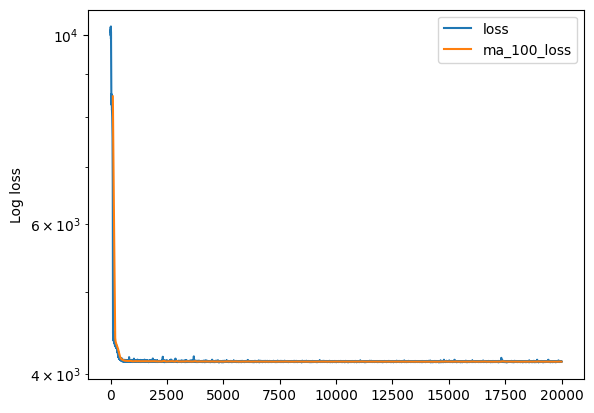

In [151]:
loss_df = pd.DataFrame()
loss_df["loss"] = loss_history
loss_df["ma_100_loss"] = loss_df["loss"].rolling(100).mean()
ax = loss_df.plot(y='loss', logy=True)
loss_df.plot(y='ma_100_loss', ax=ax)
ax.set_ylabel("Log loss")

### Evaluation

In [139]:
def eur_call_analytical_price(S, t, K, sigma):
    t2m = t  # Time to maturity (assumed in years)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m) / (sigma * torch.sqrt(t2m))
    d2 = d1 - sigma * torch.sqrt(t2m)
    # Normal cumulative distribution function (CDF)
    N0 = lambda value: 0.5 * (1 + torch.erf(value / (2**0.5)))
    Nd1 = N0(d1)
    Nd2 = N0(d2)
    # Calculate the option price
    C = S * Nd1 - K * Nd2 * torch.exp(-r * t2m)
    return C

In [140]:
eur_call_analytical_price(torch.tensor([80]),torch.tensor([1]),torch.tensor([70]), sigma =0.30)

tensor([17.0150])

In [141]:
X_test,_ = get_diff_data(1000)
t_test = torch.from_numpy(X_test[:,0]).float()
S_test = torch.from_numpy(X_test[:,1]).float()

y_analytical_test = eur_call_analytical_price(S_test,t_test,torch.tensor([K]), sigma = sigma)

In [142]:
y_pinn_test = model(torch.from_numpy(X_test).float())

Text(0.5, 1.0, 'European Call Option pricing')

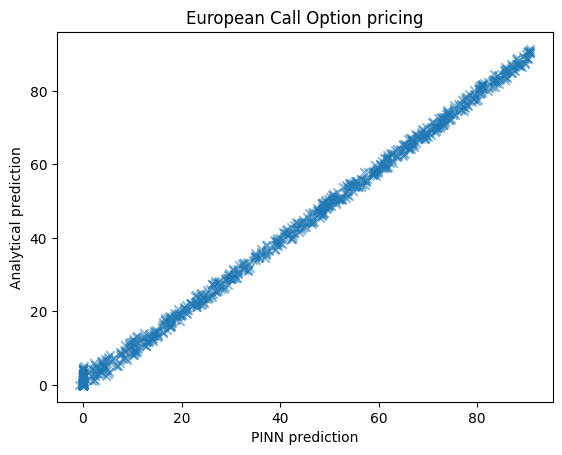

In [152]:
plt.scatter(x= y_pinn_test.detach().numpy(), y = y_analytical_test.detach().numpy(), marker = "x", alpha = 0.5)
plt.xlabel("PINN prediction")
plt.ylabel("Analytical prediction")
plt.title("European Call Option pricing")

In [158]:
y_pinn_test.detach().numpy().shape

(1000, 1)

In [161]:
np.corrcoef(y_pinn_test.detach().numpy().reshape(1000,),y_analytical_test.detach().numpy())

array([[1.        , 0.99931414],
       [0.99931414, 1.        ]])

In [144]:
%matplotlib inline

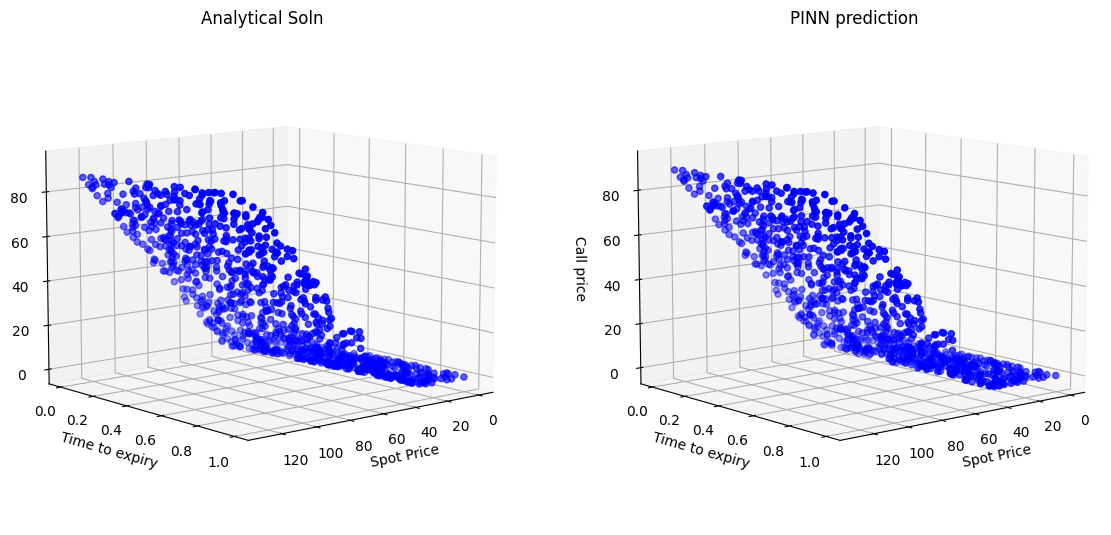

In [145]:
S, T = np.meshgrid(X_test[:,1], X_test[:,0])
# Create the 3D plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(S_test, t_test, y_analytical_test, c='b', marker='o')
ax.set_title("Analytical Soln")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=10, azim=50)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(S_test, t_test, y_pinn_test.detach().numpy(), c='b', marker='o')
ax.set_title("PINN prediction")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=10, azim=50)